In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
import functions as fc
import os
from simul_ising import Metropolis  #  On importe la classe.
from tqdm import tqdm # Pour afficher où on est rendu dans la série de simulations.

data_folder = "data/" # Ne pas oublier le "/" après. Si en windows, c'est "\"
top_dir = os.getcwd()
plt.rcParams['font.size'] = 14

## TODO
* Code pour calculer la taille des composantes (îlots) -> varier la dimension de la grille pour betaJ fixé afin de voir l'effet sur la distribution
* Boucle d'hystérésis avec fill_between pour variabilité selon seeds différentes (mémorisées)
* 

## 1 - Simulation exploratoire

In [2]:
start_time = time.time()

# Créer une instance de la classe Metropolis avec les paramètres souhaités
metropolis = Metropolis(n_iter=0, 
                        lattice_size=64, 
                        magnetic_field=0.1, 
                        betaJ=1, 
                        pourcentage_up=0.6, 
                        convol="scipy", 
                        n_iter_max=int(1e9), 
                        seed=42,
                        deltaE_static=1e-4, 
                        deltaE_buffer=300
                        )

# Trouver l'état d'équilibre en utilisant la méthode "run"
lattices, spin_means, energy_list = metropolis.run()
step_algo = np.arange(0, len(spin_means), 1) # Itérations de la "descente" Metropolis

print("Temps d'exécution : ", time.time() - start_time)


Temps d'exécution :  5.441155672073364


<Figure size 1200x400 with 0 Axes>

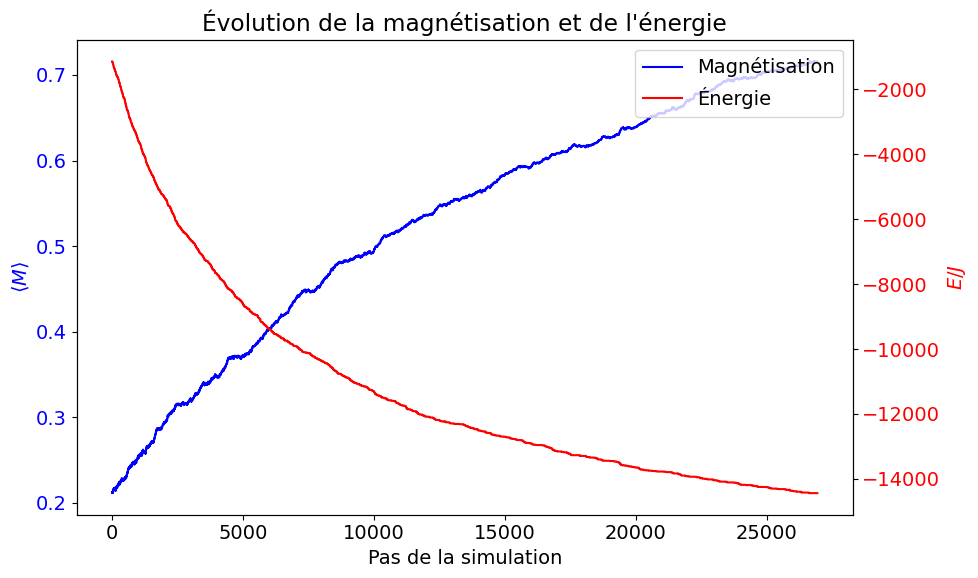

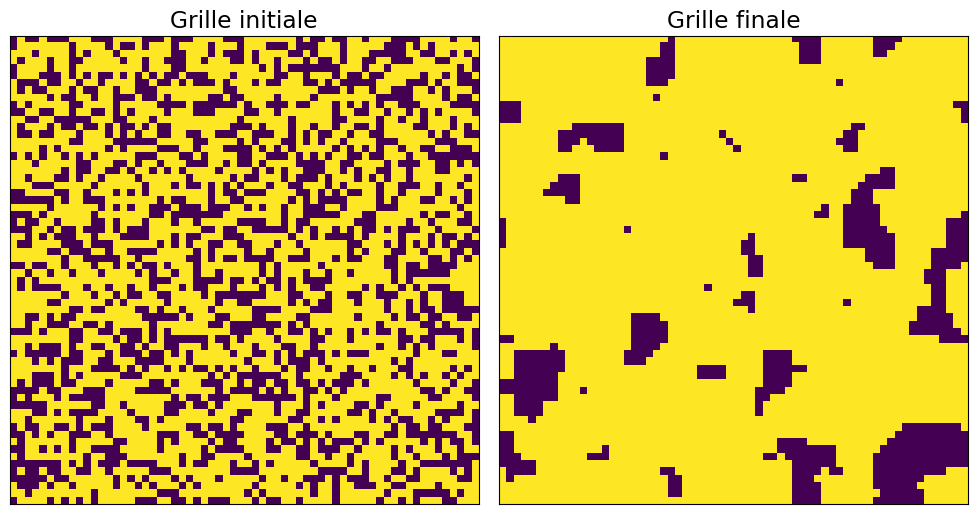

In [3]:
plt.figure(figsize=(12, 4))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(step_algo, spin_means, 'b-', label='Magnétisation')
ax1.set_xlabel("Pas de la simulation")
ax1.set_ylabel(r"$\langle M \rangle$", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(step_algo, energy_list, 'r-', label='Énergie')
ax2.set_ylabel(r"$E/J$", color='r')
ax2.tick_params(axis='y', labelcolor='r')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title("Évolution de la magnétisation et de l'énergie")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(lattices[0], vmin=-1, vmax=1)
plt.title("Grille initiale")
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(lattices[-1], vmin=-1, vmax=1)
plt.title("Grille finale")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## 2 - Simulations multiples

1) Faire un dossier pour chaque série de simulations, quelle qu'elle soit. 
2) Enregistrer les multiples simuls pour aller chercher la variabilité de type (incertitude de type A) dans un même hdf5. 
3) Nouveau hdf5 pour nouvelle valeur de champ $h$ ou de tout autre paramètre, par exemple le pourcentage de spin up à l'état initial.
4) Faire un dossier différent pour chaque valeur de température ($\beta J$) essayée -> Permettra de calculer l'aire de la boucle d'hystérésis selon $\beta J$. 

In [58]:
def run_batch_simulations(h_vec, n_seeds, base_path, betaJ=0.5, size=64, enreg=True):

    pourcentage_up=0.5
    deltaE_static=1e-4
    deltaE_buffer=300
    file_suffix=".h5"

    seed_stack = []
    mag_f_vec_stack = []
    E_f_vec_stack = []
    grille_f_vec_stack = []

    for i in range(n_seeds):
        seed = int(i+1) # Arbitrairement, on injecte i comme seed!
        seed_stack.append(i)
        derniere_grille = None # On réinitialise la grille à chaque seed, pour une nouvelle boucle d'hystérésis

        mag_f_vec = [] # Vecteur de <M>_f selon vecteur de h (pour seed donnée)
        E_f_vec = [] # Vecteur de E_f selon vecteur de h (pour seed donnée)
        grille_f_vec = [] # Liste contenant les grilles finales, pour chaque h balayé

        for h in tqdm(h_vec, desc="Variation du champ magnétique"):
            sim = Metropolis(
                n_iter=0,
                lattice_size=size,
                magnetic_field=h,
                previous_lattice=derniere_grille,
                betaJ=betaJ,
                pourcentage_up=pourcentage_up,
                convol="scipy",
                seed=seed,
                deltaE_static=deltaE_static, 
                deltaE_buffer=deltaE_buffer
            )

            lattices_timeseries, mag_timeseries, energy_timeseries = sim.run()

            mag_f_vec.append(mag_timeseries[-1])
            E_f_vec.append(energy_timeseries[-1])
            derniere_grille = lattices_timeseries[-1] # Enregistrement de la dernière grille, pour repartir d'elle comme condition initiale
            grille_f_vec.append(derniere_grille)

        mag_f_vec_stack.append(mag_f_vec)
        E_f_vec_stack.append(E_f_vec)
        grille_f_vec_stack.append(grille_f_vec)

    if enreg:
        # Fichier propre à chaque seed
        filename = f"{base_path}__{file_suffix}"

        data_dict = {
            # Éléments dynamiques, propres à aux simulations individuelles
            "grille_f": np.array(grille_f_vec_stack),
            "E_f": np.array(E_f_vec_stack),
            "M_f": np.array(mag_f_vec_stack),
            "betaJ": np.array([sim.betaJ]),
            "h": np.array(h_vec),

            # Éléments statiques, propres à la batch de simuls
            "seed" : seed_stack,
            "pourcentage_up": sim.up_perc,
            "n_iter": sim.n_iter,
            "convol" : sim.convol.encode('utf-8'),  # string deviennent des bytes pour HDF5
            "deltaE_static" : sim.deltaE_static,
            "deltaE_buffer" : sim.deltaE_buffer
        }

        fc.save_hdf5(filename, data_dict)

    return np.array(mag_f_vec_stack), np.array(E_f_vec_stack), np.array(grille_f_vec_stack)


In [59]:
enreg=False
simulation_type = "hysteresis" # hysteresis, ou quelque chose d'autre (à suivre)
h_vec = np.concatenate([np.linspace(-2, 1.5, 8), np.linspace(2, -2, 9)])
betaJ = 0.7

print("Simulation : ", simulation_type)
print("Valeurs de h balayées :", h_vec)

Simulation :  hysteresis
Valeurs de h balayées : [-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   1.5  1.   0.5  0.  -0.5
 -1.  -1.5 -2. ]


In [60]:
sim_id = len(fc.identify_files(top_dir+"/Data", keywords=[simulation_type]))
sim_folder = top_dir + "/Data/" + simulation_type + f"_betaJ={betaJ}".format(sim_id)
fc.create_folder(sim_folder)

filename = sim_folder + "/" + "simul_" + simulation_type # Juste le noyau du nom de fichier
mag_data, Ef_data, grille_data = run_batch_simulations(h_vec, n_seeds=3, betaJ=betaJ, base_path=filename, enreg=enreg)

[Errno 17] File exists: '/home/arleg/GitHub/projet_physnum/physnum25/Data/hysteresis_betaJ=0.7'


Variation du champ magnétique: 100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


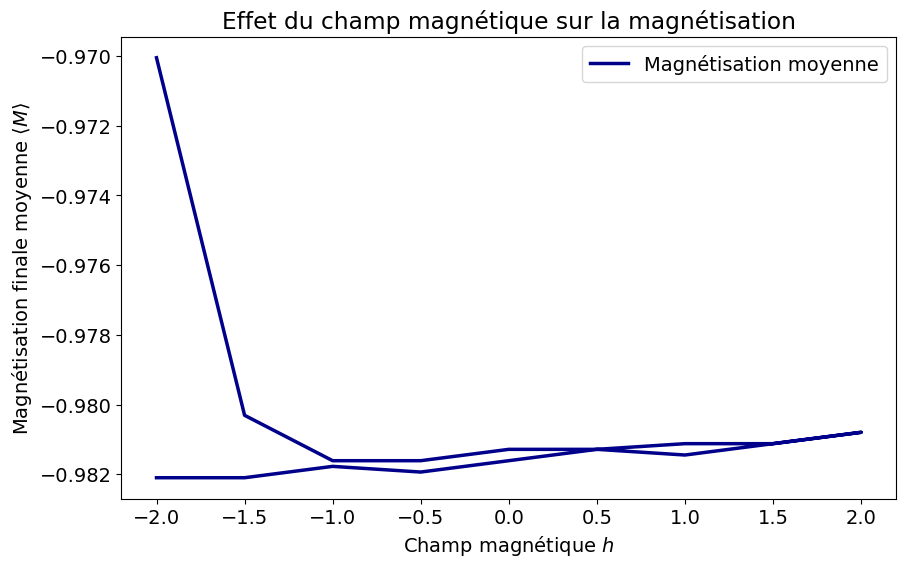

In [65]:
plt.figure(figsize=(10,6))
plt.plot(h_vec, np.mean(mag_data,axis=0), color="darkBlue", linewidth=2.5, label="Magnétisation moyenne")
plt.xlabel(r"Champ magnétique $h$")
plt.ylabel(r"Magnétisation finale moyenne $\langle M \rangle $")
plt.title("Effet du champ magnétique sur la magnétisation")
plt.legend()
plt.show()

# 3 - Chargement des données de simulation

## À METTRE À JOUR. NON FONCTIONNEL POUR L'INSTANT.

In [ ]:
def load_simulation(filename):
    data = {}

    with h5py.File(filename, 'r') as f:
        for h_group_name in f:
            h_grp = f[h_group_name]
            h_val = h_grp.attrs["magnetic_field"]

            magnetizations = []
            energies = []
            seeds = []
            attrs_list = []

            for run_name in h_grp:
                run_grp = h_grp[run_name]
                magnetizations.append(run_grp["magnetization"][()])
                energies.append(run_grp["energy"][()])
                seeds.append(run_grp.attrs["seed"])
                attrs_list.append(dict(run_grp.attrs))

            max_length = max(len(m) for m in magnetizations)
            magnetizations = [np.pad(m, (0, max_length - len(m)), constant_values=np.nan) for m in magnetizations]
            energies = [np.pad(e, (0, max_length - len(e)), constant_values=np.nan) for e in energies]

            data[h_val] = {
                "magnetizations": np.array(magnetizations),  # shape = (n_runs, n_iter+1)
                "energies": np.array(energies),
                "seeds": np.array(seeds),
                "attrs": attrs_list,  # liste de dictionnaires (si tu veux les autres attributs)
            }

    return data

In [ ]:
def load_simulation(filename):
    data = {}

    with h5py.File(filename, 'r') as f:
        for h_group_name in f:
            h_grp = f[h_group_name]
            h_val = h_grp.attrs["magnetic_field"]

            magnetizations = []
            energies = []
            seeds = []
            attrs_list = []

            for run_name in h_grp:
                run_grp = h_grp[run_name]
                magnetizations.append(run_grp["magnetization"][()])
                energies.append(run_grp["energy"][()])
                seeds.append(run_grp.attrs["seed"])
                attrs_list.append(dict(run_grp.attrs))

            data[h_val] = {
                "magnetizations": np.array(magnetizations),  # shape = (n_runs, n_iter+1)
                "energies": np.array(energies),
                "seeds": np.array(seeds),
                "attrs": attrs_list,  # liste de dictionnaires (si tu veux les autres attributs)
            }

    return data


In [ ]:
data = load_simulation("data/resultats.h5")

for h_val in sorted(data):
    mags = data[h_val]["magnetizations"]
    final_mags = mags[:, -1]
    mean = final_mags.mean()
    std = final_mags.std()
    print(f"h = {h_val:+.2f} -> Magnétisation finale : moyenne = {mean:.3f}, écart-type = {std:.3f}")


In [ ]:
h_vals = sorted(data)
means = [data[h]["magnetizations"][:, -1].mean() for h in h_vals]
stds = [data[h]["magnetizations"][:, -1].std() for h in h_vals]

plt.figure()
plt.plot(h_vals, means, label="Magnétisation finale moyenne")
plt.fill_between(h_vals,
                 np.array(means) - np.array(stds),
                 np.array(means) + np.array(stds),
                 alpha=0.3, label="Écart-type")
plt.xlabel("Champ magnétique h")
plt.ylabel("Magnétisation finale moyenne")
plt.title("Courbe extraite des résultats")
plt.legend()
plt.show()


# Code perdu

In [ ]:
def save_simulation_to_hdf5(filename, h_val, run_id, sim, lattices, spin_means, energy_list):
    with h5py.File(filename, 'a') as f:
        h_group_name = f"h={h_val:+.2f}"
        if h_group_name not in f:
            h_grp = f.create_group(h_group_name)
            h_grp.attrs["magnetic_field"] = h_val
        else:
            h_grp = f[h_group_name]

        run_group_name = f"run_{run_id:04d}"
        if run_group_name in h_grp:
            print(f"Warning: {h_group_name}/{run_group_name} already exists. Skipping save.")
            return

        run_grp = h_grp.create_group(run_group_name)
        run_grp.create_dataset("initial_lattice", data=sim.lattice)
        run_grp.create_dataset("final_lattice", data=lattices[-1])
        run_grp.create_dataset("energy", data=energy_list)
        run_grp.create_dataset("magnetization", data=spin_means)

        # Attributs du run
        run_grp.attrs["seed"] = sim.seed
        run_grp.attrs["betaJ"] = sim.betaJ
        run_grp.attrs["pourcentage_up"] = sim.up_perc
        run_grp.attrs["n_iter"] = sim.n_iter
        run_grp.attrs["convol"] = sim.convol

def run_batch_simulations(h_range, n_seeds, filename="results.h5"):
    betaJ = 1.0
    size = 64
    pourcentage_up = 0.5

    final_magnetizations = []
    std_magnetizations = []

    for h in tqdm(h_range, desc="Variation du champ magnétique"):
        mags = []
        for run_id in range(n_seeds):
            seed = np.random.randint(0, int(1e6))
            sim = Metropolis(
                n_iter=0,
                lattice_size=size,
                magnetic_field=h,
                betaJ=betaJ,
                pourcentage_up=pourcentage_up,
                convol="scipy",
                seed=seed
            )
            lattices, spin_means, energy_list = sim.run()
            save_simulation_to_hdf5(filename, h, run_id, sim, lattices, spin_means, energy_list)
            mags.append(spin_means[-1])

        final_magnetizations.append(np.mean(mags))
        std_magnetizations.append(np.std(mags))

    return h_range, final_magnetizations, std_magnetizations


In [ ]:
dataset_name = "run_0001"  # Remplacez par le nom du groupe que vous voulez lire

data= {}

with h5py.File(data_folder + "results.h5", "r") as file:
    print("Clefs du fichier :", list(file.keys()))
    
    if dataset_name in file:
        group = file[dataset_name]
        data= group
        print(f"Attributs du groupe {dataset_name}:", dict(group.attrs))
        initial_lattice = group["initial_lattice"][:]
        final_lattice = group["final_lattice"][:]
        energy = group["energy"][:]
        magnetization = group["magnetization"][:]
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Grille initiale")
        plt.imshow(initial_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.title("Grille finale")
        plt.imshow(final_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        print("Énergie :", energy)
        print("Magnétisation :", magnetization)
    else:
        print(f"Le groupe {dataset_name} n'existe pas dans le fichier.")